In [ ]:
!python --version

Python 3.10.12


In [ ]:
import tensorflow as tf
tf.__version__

'2.14.0'

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Creates a session with device placement logs
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
print(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [ ]:
# GPU for training.
DEVICE ="gpu:0"  # /cpu:0 or /gpu:0

In [ ]:
import os

# Set the desired directory path
directory_path = "/content/drive/MyDrive/Colab Notebooks/Mask-R-CNN-using-Tensorflow2"

# Change the current working directory to the specified path
os.chdir(directory_path)

In [ ]:
!python custom_pf.py

2023-12-04 06:35:17.937918: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-04 06:35:17.937975: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-04 06:35:17.938011: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-04 06:35:19.023388: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-12-04 06:35:30.165939: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-12-04 06:35:41.49

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import random
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from mrcnn1 import utils
from mrcnn1 import visualize
from mrcnn1.visualize import display_images
from mrcnn1.visualize import display_instances
import mrcnn1.model as modellib
from mrcnn1.model import log
from mrcnn1.config import Config
from mrcnn1 import model as modellib, utils

# Root directory of the project
#ROOT_DIR = "D:\MRCNN_tensorflow2.7_env\Mask-RCNN"
ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library


# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")


In [ ]:

class CustomConfig(Config):
    """Configuration for training on the custom  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"


    # NUMBER OF GPUs to use. When using only a CPU, this needs to be set to 1.
    GPU_COUNT = 1

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # Background + 5 classes

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 10

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

In [ ]:
class InferenceConfig(CustomConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    #Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.7

    # Non-maximum suppression threshold for detection
    DETECTION_NMS_THRESHOLD = 0.3

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference",
                          config=inference_config,
                          model_dir=DEFAULT_LOGS_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")


#model_path = model.find_last()
# model_path = '/content/drive/MyDrive/Colab Notebooks/Mask-R-CNN-using-Tensorflow2/logs/object20231025T0256/mask_rcnn_object_0300.h5'  # pm
# model_path = '/content/drive/MyDrive/Colab Notebooks/Mask-R-CNN-using-Tensorflow2/logs/object20231112T0804/mask_rcnn_object_0300.h5'  # pf
# model_path = '/content/drive/MyDrive/Colab Notebooks/Mask-R-CNN-using-Tensorflow2/logs/object20231113T0838/mask_rcnn_object_0300.h5'  # po


model_path = '/content/drive/MyDrive/Colab Notebooks/Mask-R-CNN-using-Tensorflow2/logs/object20231130T0840/mask_rcnn_object_0150.h5' #pf
# model_path ='/content/drive/MyDrive/Colab Notebooks/Mask-R-CNN-using-Tensorflow2/logs/object20231204T0635/mask_rcnn_object_0150.h5'
# Load trained weights
print("Loading weights from ", model_path)
model.keras_model.load_weights(model_path, by_name=True)




Loading weights from  /content/drive/MyDrive/Colab Notebooks/Mask-R-CNN-using-Tensorflow2/logs/object20231130T0840/mask_rcnn_object_0150.h5


In [ ]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset,json_path):
        """Load a subset of the Dog-Cat dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.

        # Add classes. We have only one class to add.
        self.add_class("object", 1, "pf")
        self.add_class("object", 2, "wbc")
        # self.add_class("object", 1, "pf")
        # self.add_class("object", 2, "pm")
        # self.add_class("object", 3, "po")
        # self.add_class("object", 4, "pv")
        # self.add_class("object", 5, "wbc")



        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # We mostly care about the x and y coordinates of each region
        annotations1 = json.load(open(json_path))
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']]
            objects = [s['region_attributes']['names'] for s in a['regions']]
            print("objects:",objects)
            # name_dict = {"pf": 1,"pm": 2,"po": 3,"pv": 4,"wbc": 5}
            name_dict = {"pf": 1,"wbc": 2}


            # key = tuple(name_dict)
            num_ids = [name_dict[a] for a in objects]


            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a Dog-Cat dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
          # Get indexes of pixels inside the polygon and set them to 1
          rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
          mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [ ]:
# Training dataset.
dataset_train = CustomDataset()
dataset_train.load_custom("/content/drive/MyDrive/Colab Notebooks/Mask-R-CNN-using-Tensorflow2/dataset/pf", "train", '/content/drive/MyDrive/Colab Notebooks/Mask-R-CNN-using-Tensorflow2/dataset/pf/train/pf_train_json.json')
dataset_train.prepare()

# Validation dataset
dataset_val = CustomDataset()
dataset_val.load_custom("/content/drive/MyDrive/Colab Notebooks/Mask-R-CNN-using-Tensorflow2/dataset/pf", "val",'/content/drive/MyDrive/Colab Notebooks/Mask-R-CNN-using-Tensorflow2/dataset/pf/val/pf_val_json.json')
dataset_val.prepare()

objects: ['pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'wbc', 'pf']
numids [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1]
objects: ['pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'wbc', 'pf']
numids [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1]
objects: ['pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf']
numids [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
objects: ['pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'wbc', 'wbc', 'wbc', 'wbc']
numids [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2]
objects: ['pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf', 'pf']


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (25,)                 min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (25, 4)               min:   23.00000  max:  981.00000  int32
gt_mask                  shape: (1024, 1024, 25)      min:    0.00000  max:    1.00000  uint8


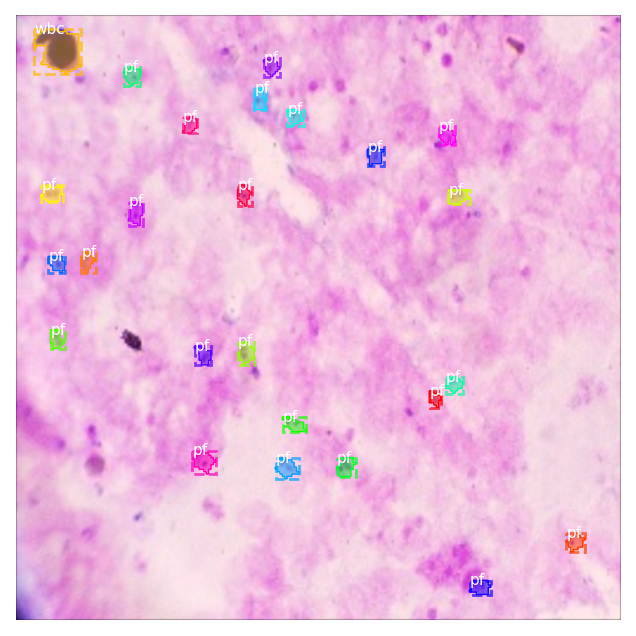

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config,
                           image_id)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id,
                            dataset_train.class_names, figsize=(8, 8))

# Testing on all unseen images at once

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  239.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -122.70000  max:  125.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


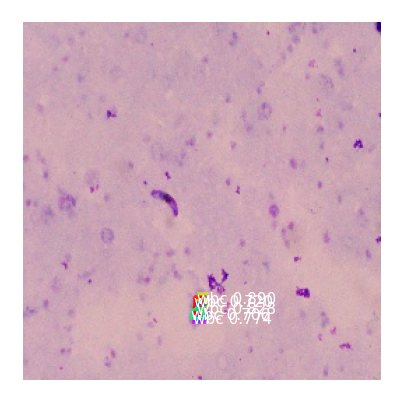

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


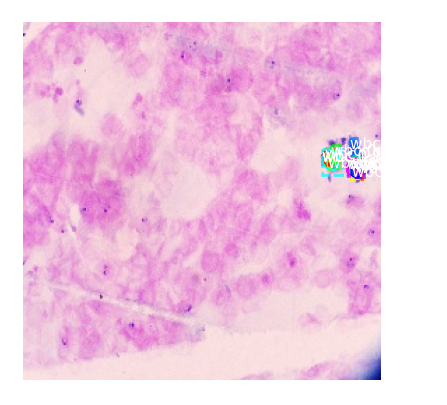

Processing 1 images
image                    shape: (256, 256, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:  -75.80000  max:  130.30000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

*** No instances to display *** 



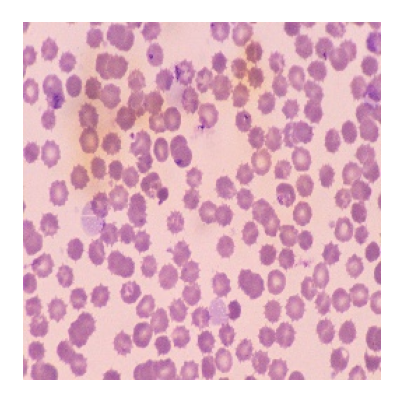

Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  230.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -112.70000  max:  104.30000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


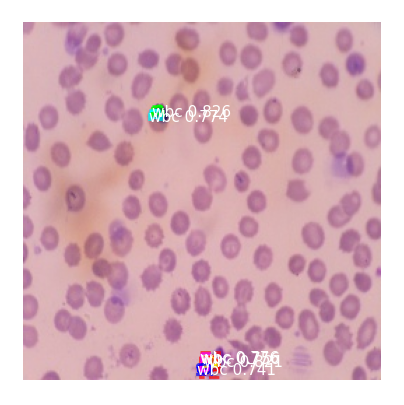

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  234.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -116.80000  max:  108.30000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


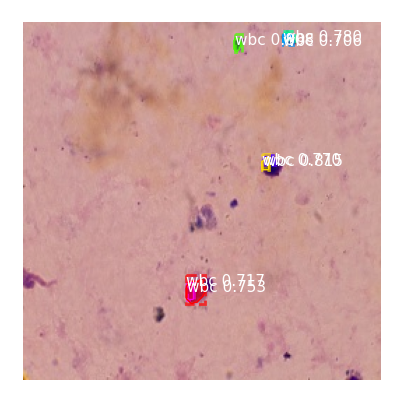

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  236.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -115.80000  max:  111.30000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


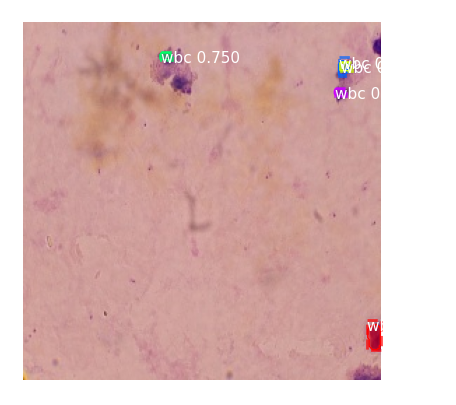

In [ ]:
import skimage
real_test_dir = '/content/drive/MyDrive/Colab Notebooks/Mask-R-CNN-using-Tensorflow2/dataset/pf/test'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'],
                                dataset_val.class_names, r['scores'], figsize=(5,5))

In [ ]:
#!pip install numpy==1.20.3
#!pip install seaborn
#!pip install sklearn
#!pip install scikit-learn

# Confusion Matrix on Validation Dataset


In [ ]:
# old numpy version was  1.19.5.


config=inference_config
dataset = dataset_val


gt_tot = np.array([])
pred_tot = np.array([])

#mAP list
mAP_ = []

#compute gt_tot, pred_tot and mAP for each image in the test dataset
for image_id in dataset.image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id)#, #use_mini_mask=False)
    info = dataset.image_info[image_id]

    # Run the model
    results = model.detect([image], verbose=1)
    r = results[0]

    #compute gt_tot and pred_tot
    gt, pred = utils.gt_pred_lists(gt_class_id, gt_bbox, r['class_ids'], r['rois'])
    gt_tot = np.append(gt_tot, gt)
    pred_tot = np.append(pred_tot, pred)

    #precision_, recall_, AP_
    AP_, precision_, recall_, overlap_ = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
    #check if the vectors len are equal
    print("the actual len of the gt vect is : ", len(gt_tot))
    print("the actual len of the pred vect is : ", len(pred_tot))

    mAP_.append(AP_)
    print("Average precision of this image : ",AP_)
    print("The actual mean average precision for the whole images", sum(mAP_)/len(mAP_))
    #print("Ground truth object : "+dataset.class_names[gt])

    #print("Predicted object : "+dataset.class_names[pred])
    # for j in range(len(dataset.class_names[gt])):
	    # print("Ground truth object : "+j)
import pandas as pd
gt_tot=gt_tot.astype(int)
pred_tot=pred_tot.astype(int)
#save the vectors of gt and pred
save_dir = "output"
gt_pred_tot_json = {"gt_tot" : gt_tot, "pred_tot" : pred_tot}
df = pd.DataFrame(gt_pred_tot_json)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
df.to_json(os.path.join(save_dir,"gt_pred_test.json"))


Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  33
the actual len of the pred vect is :  33
Average precision of this image :  0.019999999552965164
The actual mean average precision for the whole images 0.019999999552965164
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -119.70000  max:  150.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.291

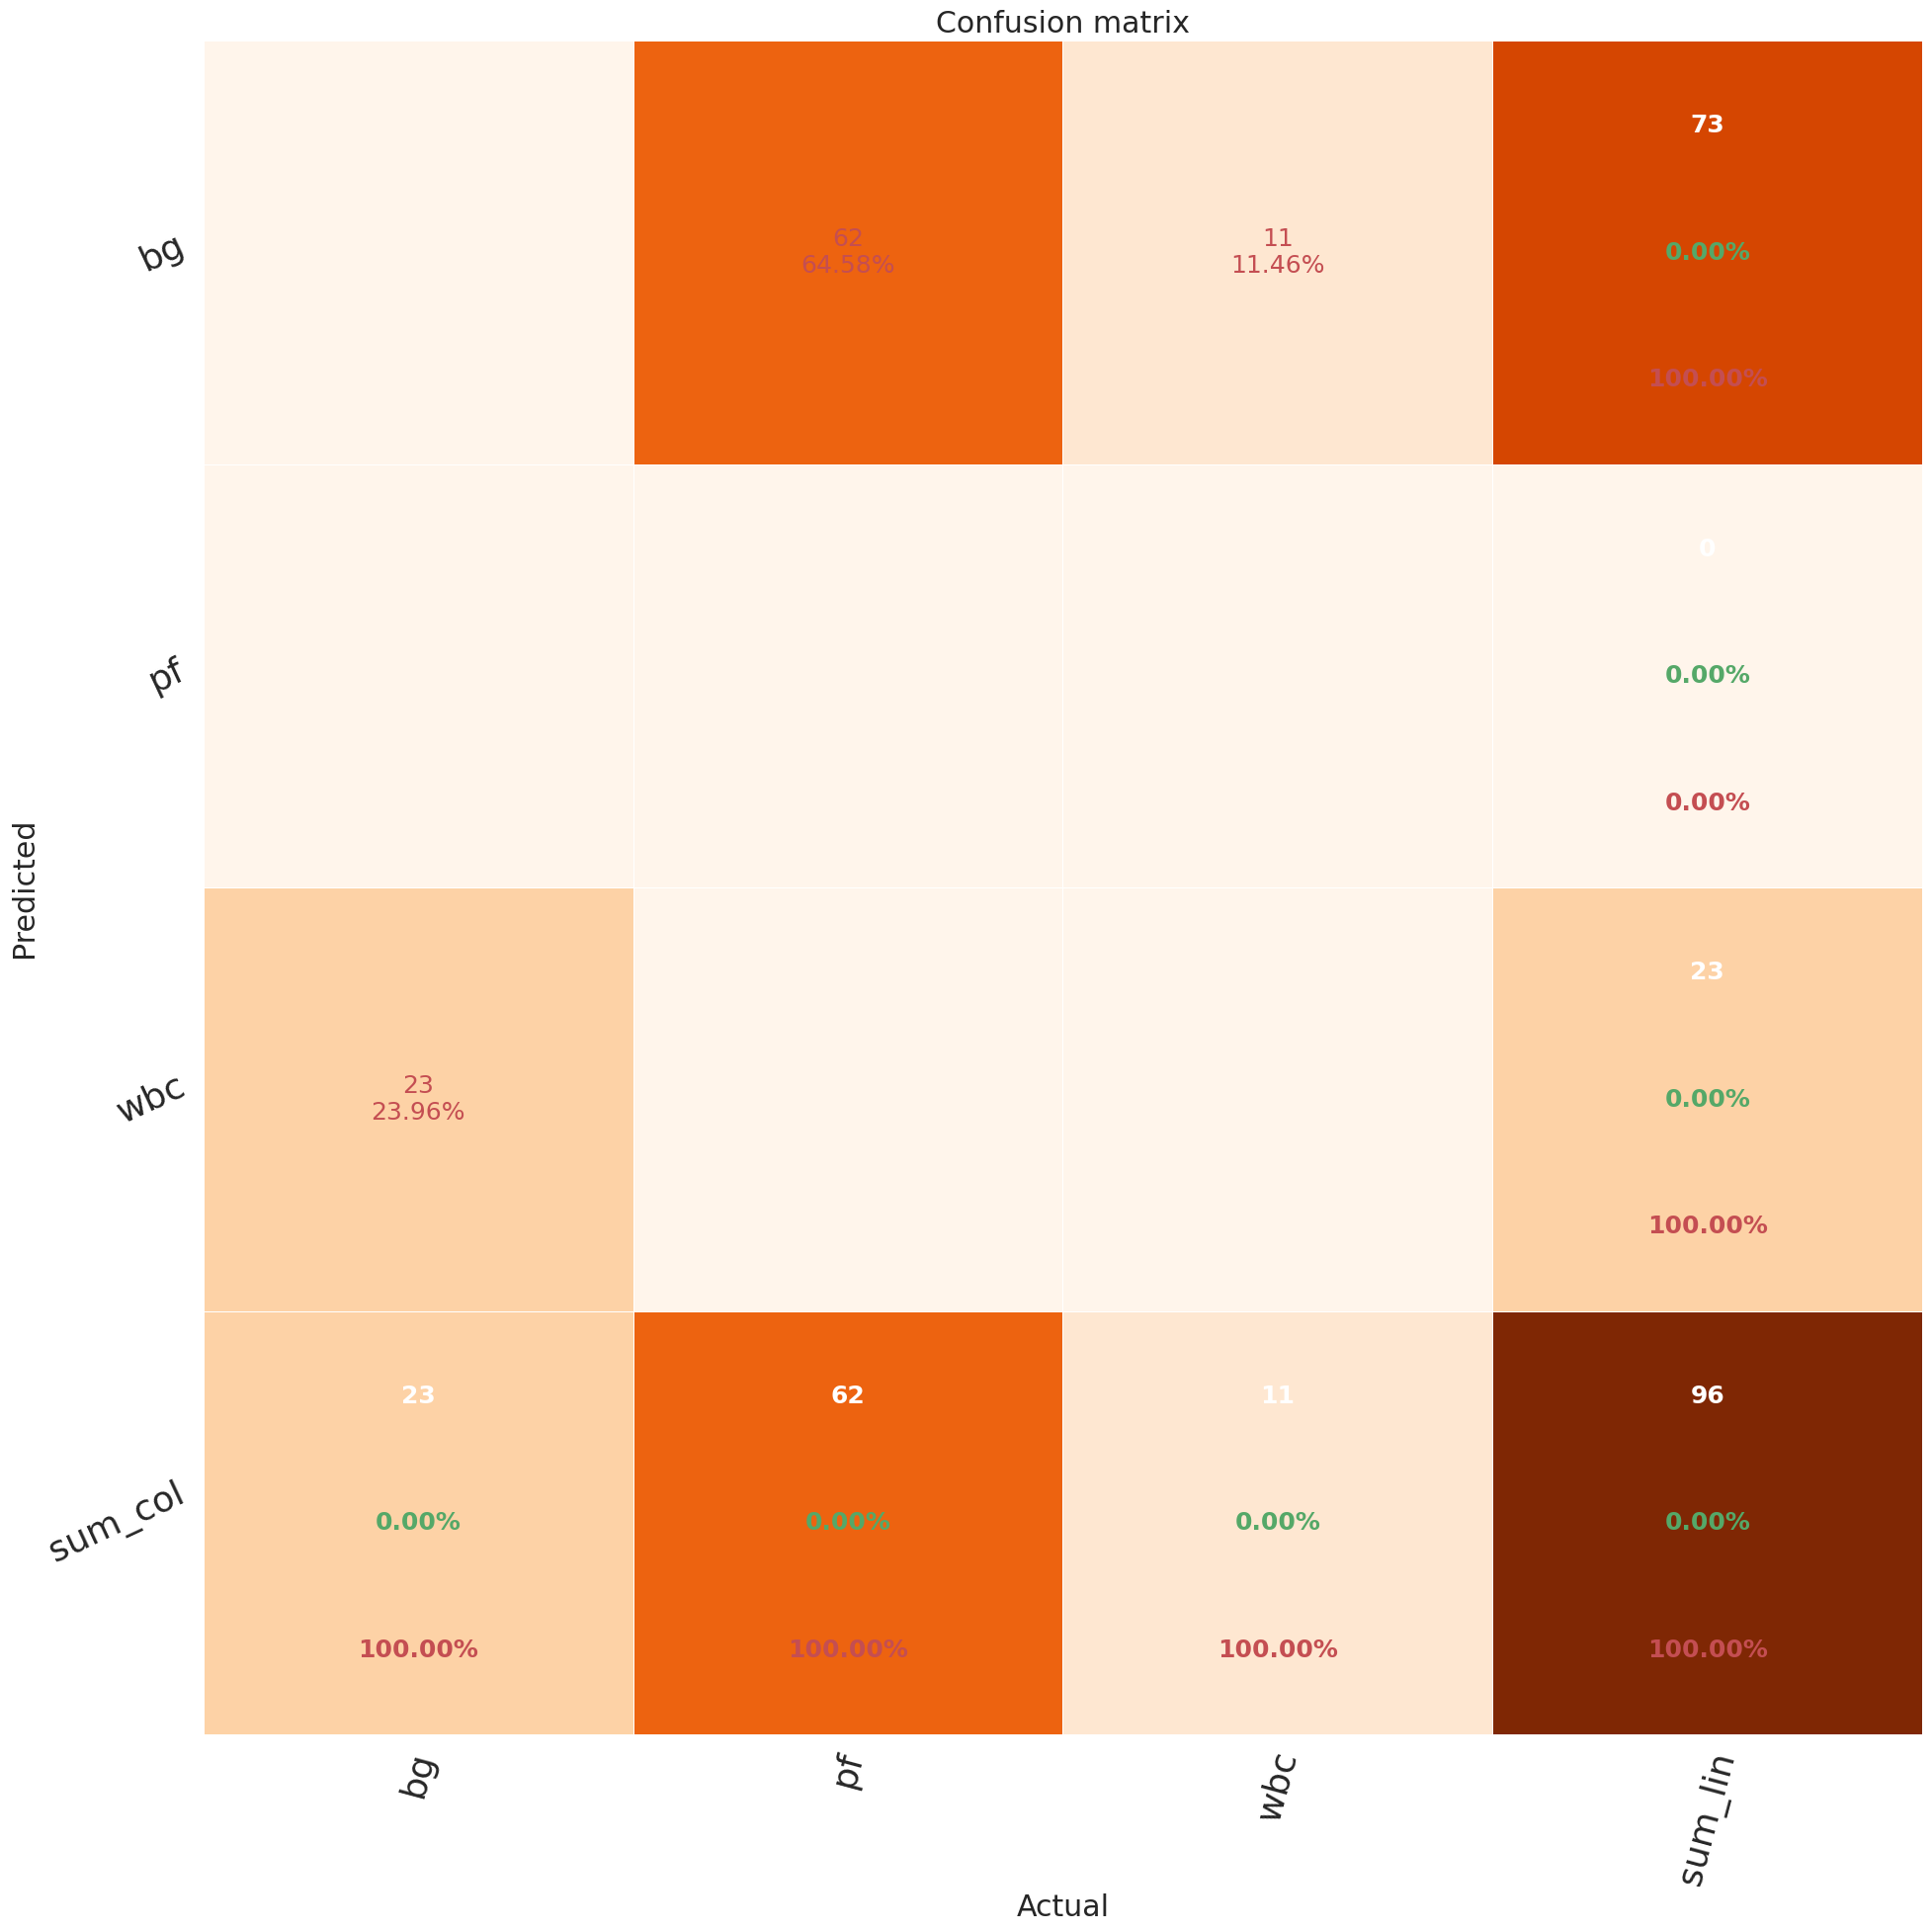

In [ ]:
tp,fp,fn=utils.plot_confusion_matrix_from_data(gt_tot,pred_tot,columns=["bg","pf","wbc"] ,fz=18, figsize=(20,20), lw=0.5)

In [ ]:
print("tp for each class :",tp)
print("fp for each class :",fp)
print("fn for each class :",fn)

#eliminate the background class from tps fns and fns lists since it doesn't concern us anymore :
del tp[0]
del fp[0]
del fn[0]
print("\n########################\n")
print("tp for each class :",tp)
print("fp for each class :",fp)
print("fn for each class :",fn)

tp for each class : [0, 0, 0]
fp for each class : [73, 0, 23]
fn for each class : [23, 62, 11]

########################

tp for each class : [0, 0]
fp for each class : [0, 23]
fn for each class : [62, 11]


# # Draw precision-recall curve  

##### The PR curve is for single detected image

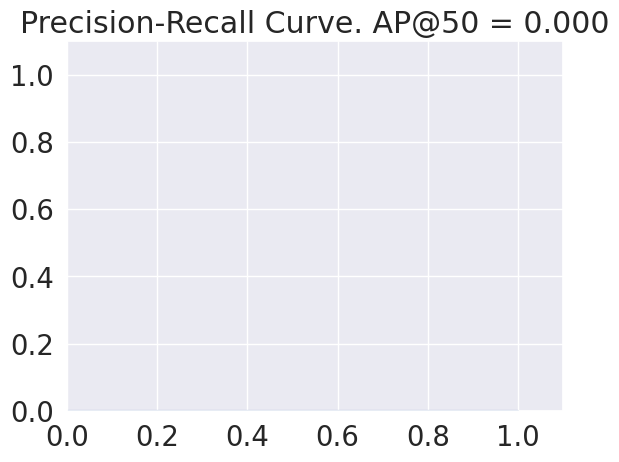

In [ ]:
# Draw precision-recall curve

AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

# calculate the mAP for a batch of validation images

Re-starting from epoch 150
Images: 6
Classes: ['BG', 'pf', 'wbc']
Loading weights  /content/drive/MyDrive/Colab Notebooks/Mask-R-CNN-using-Tensorflow2/logs/object20231130T0840/mask_rcnn_object_0150.h5
mAP @ IoU=50:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


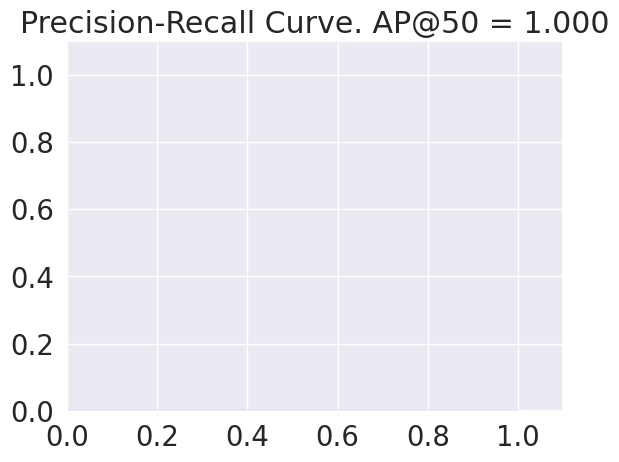

In [ ]:
path = os.getcwd()
#model_tar = "nuclei_datasets.tar.gz"
data_path = os.path.join(path + '/dataset/pf')
model_path = os.path.join(path + '/logs/object20231130T0840')
weights_path = os.path.join(model_path + '/mask_rcnn_object_0150.h5') #My weights file

DEVICE = "/gpu:0"


config=inference_config
dataset = dataset_val


with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=model_path, config=config)

model.load_weights(weights_path, by_name=True)


def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, config, image_id)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'], r['scores'], r['masks'])
        AP = 1 - AP
        APs.append(AP)
    return APs, precisions, recalls

#dataset.load_nucleus(data_path, 'val')
#dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))
print("Loading weights ", weights_path)

image_ids = np.random.choice(dataset.image_ids, 25)
APs, precisions, recalls = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", APs)

AP = np.mean(APs)
visualize.plot_precision_recall(AP, precisions, recalls)
plt.show()




# Load a random image from the images folder and perform prediction

In [ ]:

# IMAGE_DIR = os.path.join(ROOT_DIR, "/content/drive/MyDrive/Colab Notebooks/Mask-R-CNN-using-Tensorflow2/dataset/test")

# # COCO Class names
# # Index of the class in the list is its ID. For example, to get ID of
# # the teddy bear class, use: class_names.index('teddy bear')
# class_names = ['BG', 'pm', 'wbc']

# file_names = next(os.walk(IMAGE_DIR))[2]
# image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# # Run detection
# results = model.detect([image], verbose=1)

# # Visualize results
# r = results[0]
# visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],
#                             class_names, r['scores'])